In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:02<00:00, 20.64it/s]


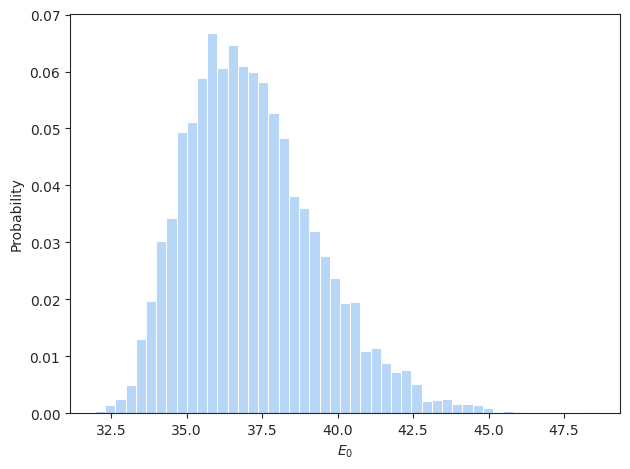

In [36]:
import numpy as np
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

from nonlocalgames.hamiltonians import G14

values = []
ham = G14(init_mode='normal')
for i in tqdm(range(5000)):
    ham.init(seed=i)
    w, _ = eigsh(ham.mat, k=1, which='LA')
    values.append(w.item())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14/g14_random_init.png', dpi=300)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%%bash

# Run trials with multiprocessing
python examples/g14/run_g14.py \
    --num-cpus=4 \
    --seeds=data/seeds.txt
    -n 50

10418.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2023-08-15 16:31:25,106	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
Starting processing
100%|███████████████████████████████████████████| 50/50 [21:37<00:00, 25.95s/it]
Postprocessing
Aggregating results


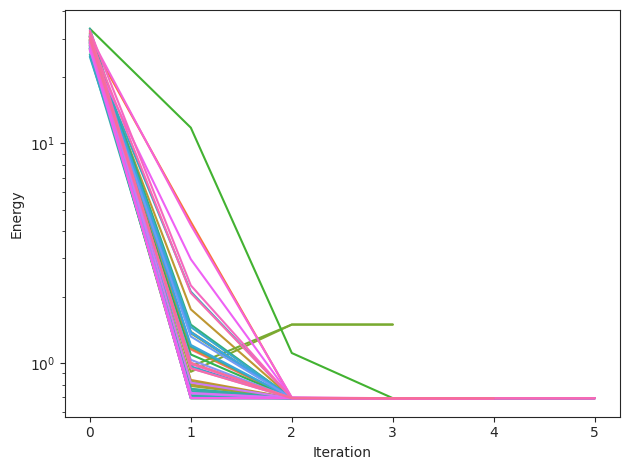

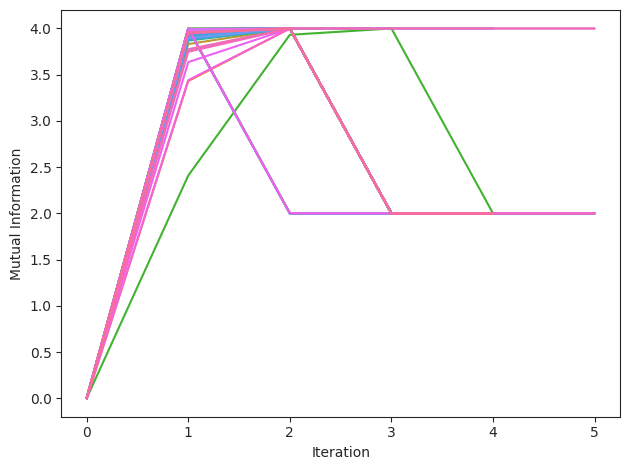

In [21]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_mutual_information.png', dpi=300)
plt.show()

### Test generated circuit

We're going to load the saved ADAPT ansatz and convert it to a Qiskit circuit. Then, we'll use the utility class `NLGCircuit` to evaluate each of the possible referee questions on G14.

In [1]:
%load_ext autoreload
%autoreload 2

2023-08-17 13:11:14,118	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


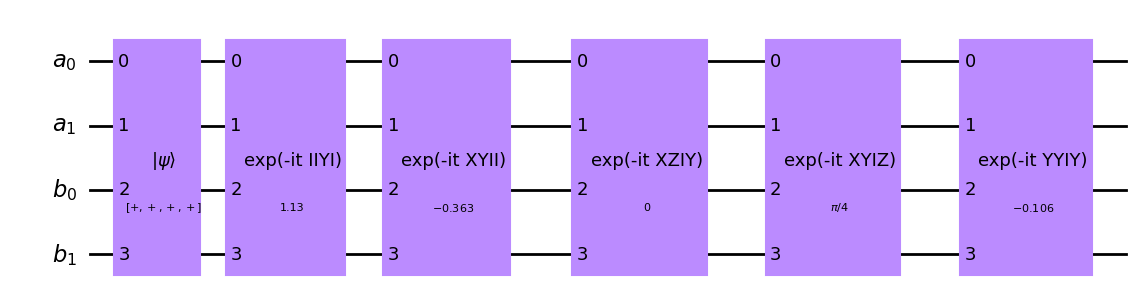

In [2]:
import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_imbalanced/g14_state.json')
shared_state.draw('mpl')

Construct the `NLGCircuit` from the ansatz, and draw it to make sure it looks reasonable.

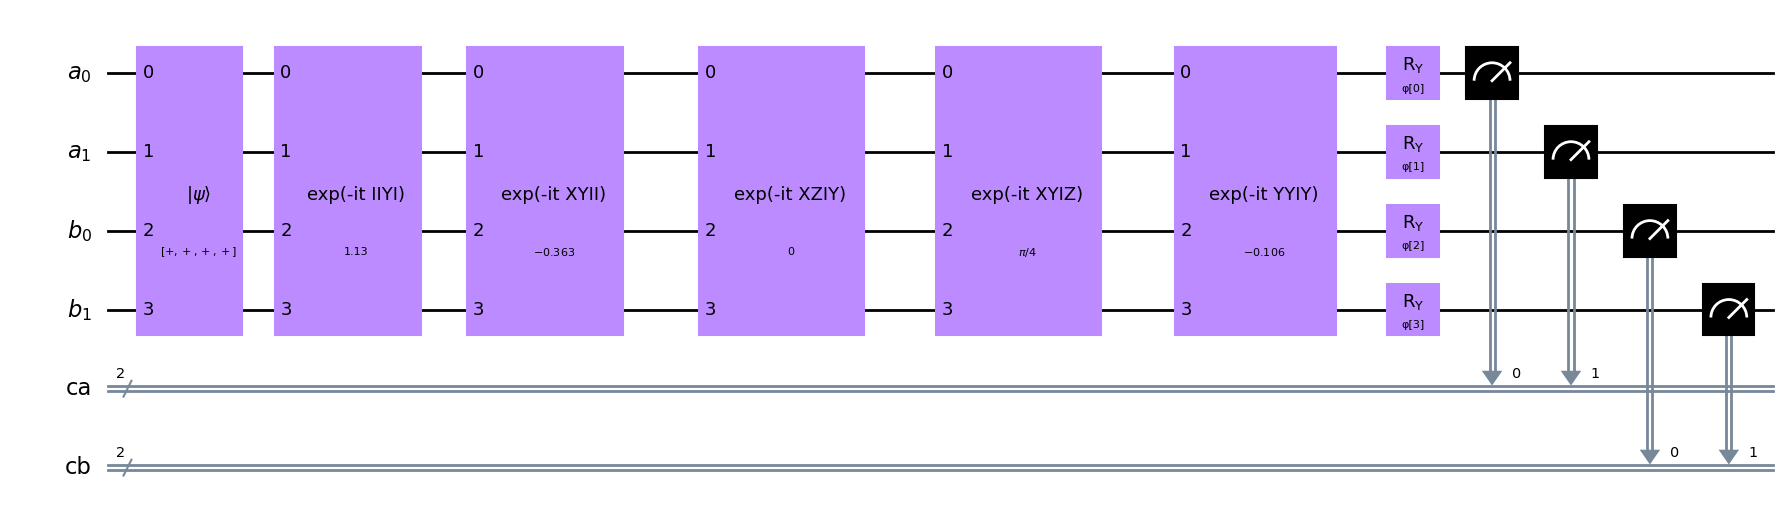

In [5]:
import matplotlib.pyplot as plt

sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
fig: plt.Figure = nlg.qc.draw('mpl')
fig.tight_layout()
fig.savefig('plots/g14_imbalanced/circuit.png', dpi=300)
fig

Here's a sample response where $v_a = v_b = 1$. The players should respond with the same color $c_a = c_b$ to win.

In [81]:
nlg.ask([1, 1], shots=1024, seed_simulator=42)

{(2, 2): 519, (3, 3): 505}

Construct a dataframe consisting of 1024 trials (shots) for each possible question.

In [82]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
N = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=N, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_imbalanced/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,0,0,519
1,0,0,1,1,505
2,1,1,2,2,519
3,1,1,3,3,505
4,2,2,0,0,519
...,...,...,...,...,...
263,10,13,1,3,477
264,11,13,0,3,519
265,11,13,1,2,505
266,12,13,2,3,519


We'd like to calculate the win rate for each question.

In [83]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / N
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / N

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr.to_csv('data/g14_imbalanced/g14_win_rate.csv', index=False)
wr

,va,vb,win_rate
0,0,0,1.000000
1,0,1,1.000000
2,0,2,0.936523
3,0,3,1.000000
4,0,4,0.936523
...,...,...,...
83,13,9,1.000000
84,13,10,1.000000
85,13,11,1.000000
86,13,12,1.000000


Plot the win rate per question type (either $v_a = v_b$ or $v_a \sim v_b$).

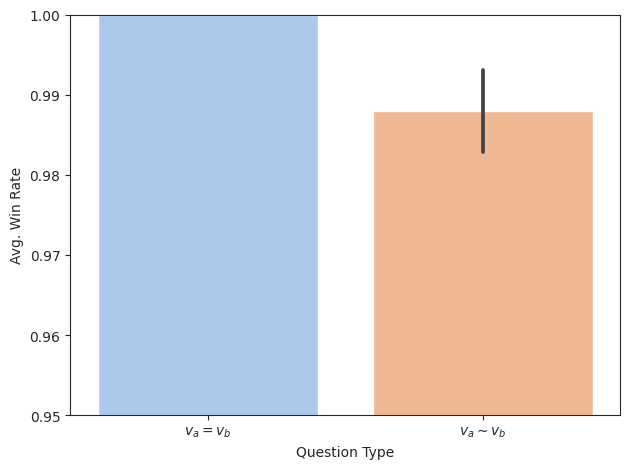

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.ylim(0.95, 1)
plt.tight_layout()
plt.savefig('plots/g14_imbalanced/g14_win_rate.png', dpi=300)
plt.show()

Calculate the balance of the question types. The fact that there's many more edge questions than vertex questions suggests we should re-weight the hamiltonian terms, similar to if we had an imbalanced dataset in a supervised learning problem.

In [87]:
print(wr.question.value_counts())

$v_a \sim v_b$    74
$v_a = v_b$       14
Name: question, dtype: int64


### G14 Balanced

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# Run trials with multiprocessing
!(python examples/g14/run_g14.py \
    --num-cpus=6 \
    --seeds=data/seeds.txt \
    -n 50 \
    --weighting=balanced \
    --adapt-tol=1e-6 \
    --dpo-tol=1e-6)

2023-08-17 16:52:41,196	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
Starting processing
100%|███████████████████████████████████████████| 50/50 [24:03<00:00, 28.87s/it]
Postprocessing
Aggregating results


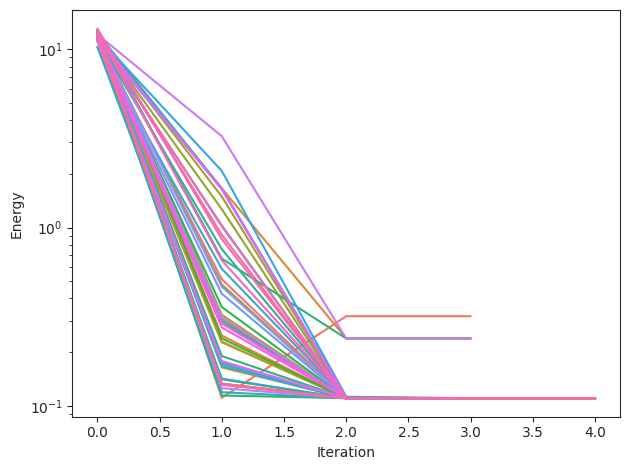

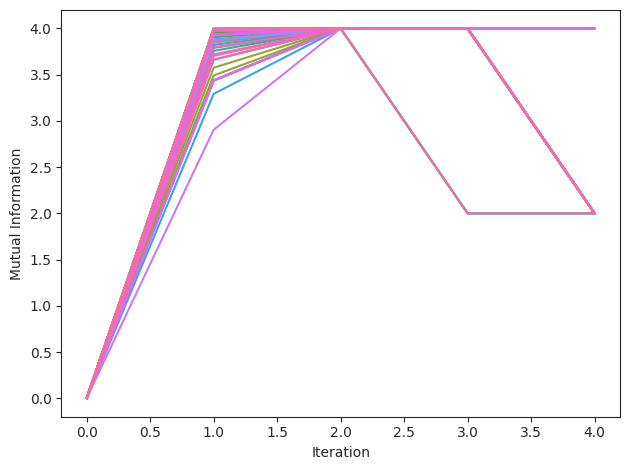

In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_balanced/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_mutual_information.png', dpi=300)
plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2023-08-17 17:18:05,153	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


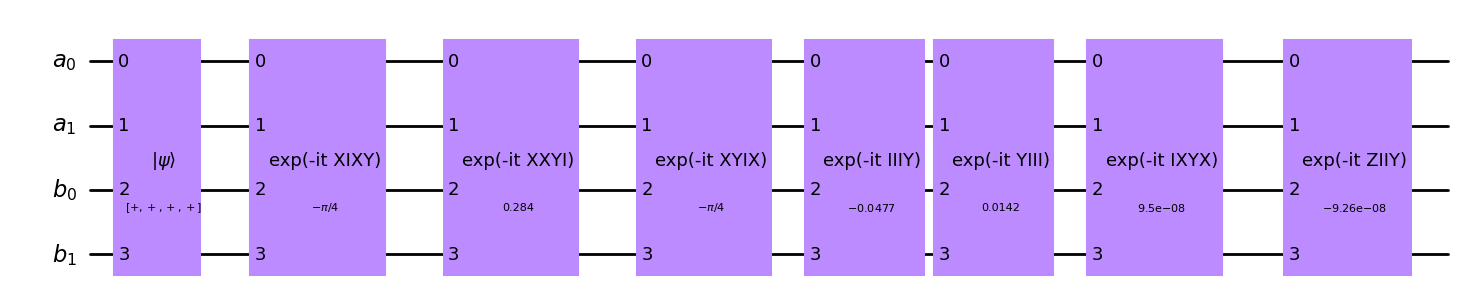

In [6]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        '++++',
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_balanced/g14_state.json')
shared_state.draw('mpl')

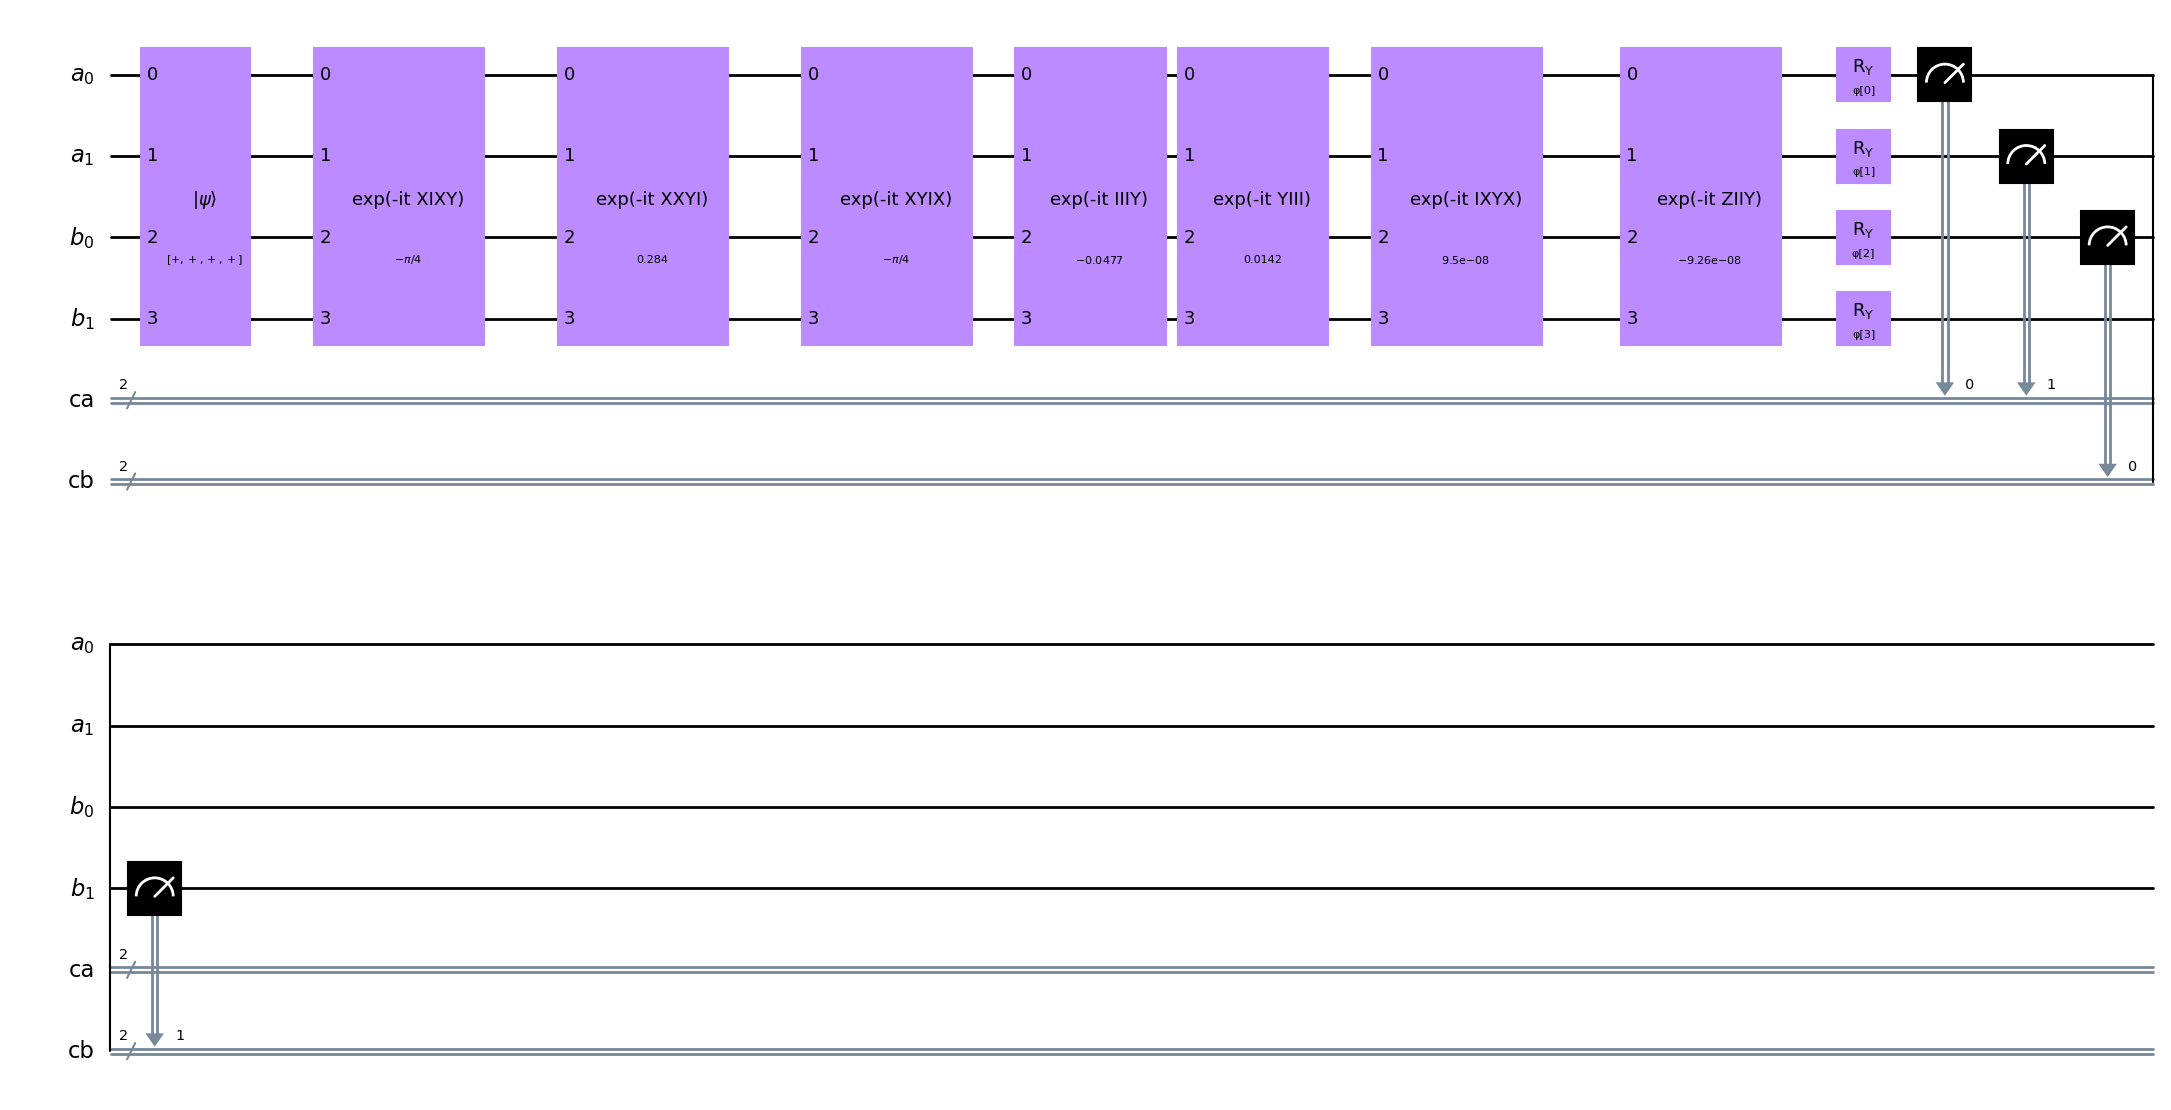

In [7]:
import matplotlib.pyplot as plt

sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
fig: plt.Figure = nlg.qc.draw('mpl')
fig.tight_layout()
fig.savefig('plots/g14_balanced/circuit.png', dpi=300)
fig

In [8]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
N = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=N, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_balanced/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,2,2,519
1,0,0,3,3,505
2,1,1,0,0,519
3,1,1,1,1,505
4,2,2,2,2,519
...,...,...,...,...,...
263,11,13,3,1,477
264,12,13,2,0,495
265,12,13,2,1,24
266,12,13,3,0,28


In [9]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / N
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / N

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr.to_csv('data/g14_balanced/g14_win_rate.csv', index=False)
wr

,va,vb,win_rate
0,0,0,1.000000
1,0,1,1.000000
2,0,2,0.936523
3,0,3,0.936523
4,0,4,1.000000
...,...,...,...
83,13,9,1.000000
84,13,10,1.000000
85,13,11,1.000000
86,13,12,1.000000


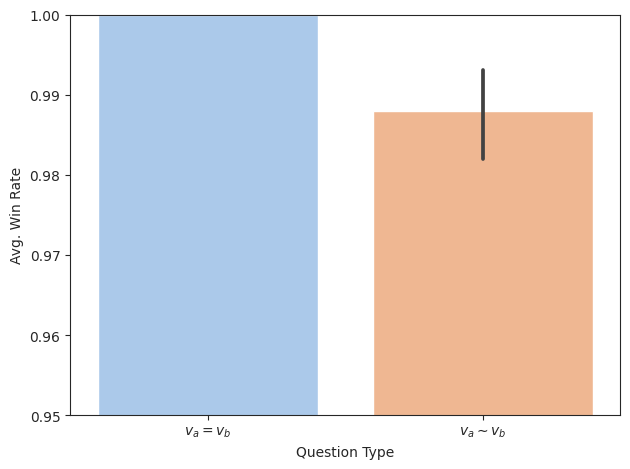

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.ylim(0.95, 1)
plt.tight_layout()
plt.savefig('plots/g14_balanced/g14_win_rate.png', dpi=300)
plt.show()

In [11]:
wr.win_rate.mean(), wr.win_rate.std()

(0.9899014559659091, 0.02335029197038263)